# Generating MNIST dataset using vanilla gan

## Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.optim as optimizer
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import PIL
from PIL import Image
import os

## Downloading Data

In [2]:
# Normalizing, so each image will have a value between -1 and 1

transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])

train_data = datasets.FashionMNIST(root = 'data', download=True, train = True, transform=transfrom)

## Visualizing Some of the images from FashionMNIST data

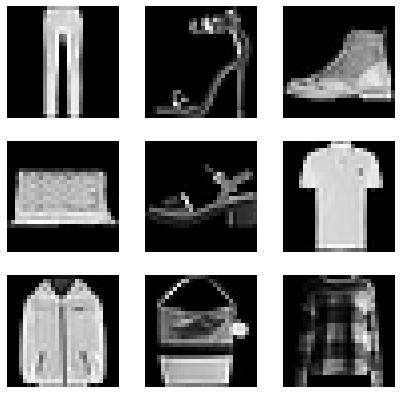

In [38]:
figure = plt.figure(figsize=(7, 7))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    j = torch.randint(60000, (1,)).item()
    img = train_data[j][0].view(28, 28).detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Defining Generator Class

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
   
    def forward(self, n):
        noise = torch.randn((n, 100))
        
        return self.layers(noise)

## Defining Discriminator Class

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(.2),
            nn.Dropout(.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(.2),
            nn.Dropout(.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(.2),
            nn.Dropout(.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, data):
        return self.layers(data)

## Model Instances

In [5]:
G = Generator()
D = Discriminator()

## Defining Optimizers and Loss Function.

In [6]:
# each model has to have its own optimizer

G_Opt = optimizer.Adam(G.parameters(), lr = 0.0002)
D_Opt = optimizer.Adam(D.parameters(), lr = 0.0002)

Loss_Func = nn.BCELoss()

## Util Functions.

In [7]:
def Generate_Fake_Data(size):
    return G(size)

def Generate_Real_Labels(size):
    return torch.ones((size, 1))

def Generate_Fake_Labels(size):
    return torch.zeros((size, 1))

In [8]:
def Save_Image(epoch):
    To_PIL = transforms.ToPILImage()
    img = To_PIL(G(1).view(28, 28))
    
    if not os.path.exists("./Images"):
        os.mkdir("./Images")
    
    img.save(f"./Images/epoch{epoch + 1}.jpg")

## Training Discriminator

In [9]:
def Train_D(Real_Data, batch_size):
    
    Real_Data = Real_Data.view(-1, 784)
        
    Fake_Data = Generate_Fake_Data(batch_size)
    
    Real_Labels, Fake_Labels = Generate_Real_Labels(batch_size), Generate_Fake_Labels(batch_size)
    
    D_Opt.zero_grad()

    Fake_Output = D(Fake_Data)
    Real_Output = D(Real_Data)
    
    realLoss = Loss_Func(Real_Output, Real_Labels)
    fakeLoss = Loss_Func(Fake_Output, Fake_Labels)
    
    d_Loss = realLoss + fakeLoss
    d_Loss.backward()
    D_Opt.step()

    return d_Loss.item()

## Training Generator

In [10]:
def Train_G(batch_size):
    
    Fake_Data = Generate_Fake_Data(batch_size)
    
    Real_Labels = Generate_Real_Labels(batch_size)
    
    G_Opt.zero_grad()
    
    D_Output = D(Fake_Data)
    
    g_Loss = Loss_Func(D_Output, Real_Labels)
    
    g_Loss.backward()
    
    G_Opt.step()
    
    return g_Loss.item()

## Training Loop

In [11]:
def Train():
    
    G_Loss, D_Loss = [], []
    G_Losses, D_Losses = [], []
    
    num_epochs = 200

    batch_size = 256

    real_dataloader = DataLoader(train_data, batch_size, shuffle=True)    
        
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}:")
        
        for batch, (Images, _) in tqdm(enumerate(real_dataloader), total=int(len(real_dataloader))):
            
            batch_size = len(Images)
            
            for i in range(1):
                D_Loss.append(Train_D(Images, batch_size))
                
            G_Loss.append(Train_G(batch_size))
        
        print(f"Discriminator Loss = {np.array(D_Loss).mean()} - Generator Loss = {np.array(G_Loss).mean()}")
        G_Losses.append(np.array(G_Loss).mean())
        D_Losses.append(np.array(D_Loss).mean())
        
        Save_Image(epoch)
        
    return G_Losses, D_Losses

In [12]:
G_Losses, D_Losses = Train()

Epoch 1:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.9279019580876574 - Generator Loss = 1.7203307092189788
Epoch 2:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5968587881508977 - Generator Loss = 4.131658659526642
Epoch 3:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4533956303082882 - Generator Loss = 5.190345806390681
Epoch 4:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4059619841542333 - Generator Loss = 5.331487775324507
Epoch 5:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3952154304087162 - Generator Loss = 5.250018978296442
Epoch 6:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3910945352800983 - Generator Loss = 5.1744223486235805
Epoch 7:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.37437197308998704 - Generator Loss = 5.181471178796154
Epoch 8:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3622404656293703 - Generator Loss = 5.156638441551873
Epoch 9:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.356068725861063 - Generator Loss = 5.114080567943289
Epoch 10:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.346556296825726 - Generator Loss = 5.029656027618875
Epoch 11:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.34500835360508825 - Generator Loss = 4.927832684791295
Epoch 12:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3459532900865302 - Generator Loss = 4.8261976002695715
Epoch 13:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.34790967331312095 - Generator Loss = 4.7268302930650075
Epoch 14:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.35103069176631313 - Generator Loss = 4.666208676210291
Epoch 15:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.352012498130401 - Generator Loss = 4.594412927483836
Epoch 16:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.35651444006968847 - Generator Loss = 4.520134547852138
Epoch 17:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3613414686644107 - Generator Loss = 4.445090684954902
Epoch 18:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3682460403303235 - Generator Loss = 4.360387386885377
Epoch 19:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.37319505106311496 - Generator Loss = 4.2988978317510105
Epoch 20:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3763179103752717 - Generator Loss = 4.238736741663294
Epoch 21:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3806230309350452 - Generator Loss = 4.192131110279997
Epoch 22:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.38379898329609485 - Generator Loss = 4.144340891458771
Epoch 23:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3880027002152693 - Generator Loss = 4.097159461479954
Epoch 24:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3923242133989243 - Generator Loss = 4.049843180533631
Epoch 25:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.3996178845706138 - Generator Loss = 3.9976138998954855
Epoch 26:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4028107811411791 - Generator Loss = 3.953544548778214
Epoch 27:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4093969738141724 - Generator Loss = 3.9067113092652073
Epoch 28:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4147298480018883 - Generator Loss = 3.8613932098797026
Epoch 29:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.42076877064385226 - Generator Loss = 3.8162199256486606
Epoch 30:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.427242014907459 - Generator Loss = 3.7692237071238512
Epoch 31:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4325072462341314 - Generator Loss = 3.7312587048431416
Epoch 32:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.43914969111346897 - Generator Loss = 3.6912741519946684
Epoch 33:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4470066503242744 - Generator Loss = 3.6463142250023837
Epoch 34:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4520851046448394 - Generator Loss = 3.6056499245878455
Epoch 35:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.45744199222752024 - Generator Loss = 3.567424830444678
Epoch 36:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4630590281627597 - Generator Loss = 3.5285667963449274
Epoch 37:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.46831201856175053 - Generator Loss = 3.4932408396542383
Epoch 38:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.47454845094041687 - Generator Loss = 3.4572460196954005
Epoch 39:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.4803370671008398 - Generator Loss = 3.420798613861878
Epoch 40:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.48691059764117955 - Generator Loss = 3.388064487979133
Epoch 41:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.492315804343197 - Generator Loss = 3.35579426923006
Epoch 42:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.49741089997781024 - Generator Loss = 3.326051191002765
Epoch 43:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5029134857752635 - Generator Loss = 3.2923210758758263
Epoch 44:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.508439702219627 - Generator Loss = 3.2619075513295326
Epoch 45:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5130745057212123 - Generator Loss = 3.2355505570029535
Epoch 46:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5176358325439647 - Generator Loss = 3.2083025000114116
Epoch 47:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5220290427812493 - Generator Loss = 3.1814212470504697
Epoch 48:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5265450771372924 - Generator Loss = 3.1561796690951636
Epoch 49:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5305838437405582 - Generator Loss = 3.132018274912563
Epoch 50:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5355197899928118 - Generator Loss = 3.106551715472911
Epoch 51:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5406949004709323 - Generator Loss = 3.0816484418644428
Epoch 52:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5452144070145859 - Generator Loss = 3.0578453209391396
Epoch 53:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5497018268507606 - Generator Loss = 3.035857654898007
Epoch 54:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5530461174496828 - Generator Loss = 3.0147198816915495
Epoch 55:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5571041265426914 - Generator Loss = 2.994415927041661
Epoch 56:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.561452873425111 - Generator Loss = 2.9739443354942696
Epoch 57:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5657391323379479 - Generator Loss = 2.9528254581125157
Epoch 58:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5692177157433634 - Generator Loss = 2.9344480580100223
Epoch 59:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5735784864432645 - Generator Loss = 2.914363732156967
Epoch 60:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5778365979911694 - Generator Loss = 2.894477345002881
Epoch 61:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5817676357311636 - Generator Loss = 2.8762352008436216
Epoch 62:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5851638141671782 - Generator Loss = 2.8579970118417752
Epoch 63:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5886053545036275 - Generator Loss = 2.8409134208069022
Epoch 64:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5914724154182353 - Generator Loss = 2.825176605691222
Epoch 65:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.594485782708991 - Generator Loss = 2.8097878054413585
Epoch 66:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.5973941233662406 - Generator Loss = 2.794105543933093
Epoch 67:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6004971131045937 - Generator Loss = 2.77920191596712
Epoch 68:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6029871299827894 - Generator Loss = 2.7651623276040165
Epoch 69:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.605975172737159 - Generator Loss = 2.7505746418831345
Epoch 70:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6089696576550467 - Generator Loss = 2.7359968425999295
Epoch 71:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6124598701398263 - Generator Loss = 2.7200184245201724
Epoch 72:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6158847343751249 - Generator Loss = 2.704831752926111
Epoch 73:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6185513056758211 - Generator Loss = 2.69098961202336
Epoch 74:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6217457528309088 - Generator Loss = 2.6760861741032937
Epoch 75:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6243040404710787 - Generator Loss = 2.662644719352113
Epoch 76:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.627223317101723 - Generator Loss = 2.649224356906478
Epoch 77:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6304277851574409 - Generator Loss = 2.6353878403655333
Epoch 78:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6334719653233715 - Generator Loss = 2.6219703401347942
Epoch 79:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6360905936409722 - Generator Loss = 2.609371679430537
Epoch 80:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.638694928930676 - Generator Loss = 2.5966501954055214
Epoch 81:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6416748382194183 - Generator Loss = 2.5840339848507976
Epoch 82:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6445594602491133 - Generator Loss = 2.571744328225346
Epoch 83:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6475066966063256 - Generator Loss = 2.559118052121463
Epoch 84:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6507677008966861 - Generator Loss = 2.5463316146650454
Epoch 85:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6537459874677195 - Generator Loss = 2.5339203457465307
Epoch 86:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6565778658496293 - Generator Loss = 2.522077272073695
Epoch 87:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6593598591332754 - Generator Loss = 2.5100439160675956
Epoch 88:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6619151324856976 - Generator Loss = 2.4989064167831923
Epoch 89:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6645239791902107 - Generator Loss = 2.4879378565512518
Epoch 90:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6669177257720531 - Generator Loss = 2.477670306408377
Epoch 91:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6694673694112757 - Generator Loss = 2.4670052871195156
Epoch 92:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6717419677580276 - Generator Loss = 2.457276037634522
Epoch 93:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6739059386566516 - Generator Loss = 2.4474320662141635
Epoch 94:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6763251673710149 - Generator Loss = 2.437757326763051
Epoch 95:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6782494522998275 - Generator Loss = 2.428865417455639
Epoch 96:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.68063034061359 - Generator Loss = 2.4192809615772983
Epoch 97:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6830733430036839 - Generator Loss = 2.409912875550283
Epoch 98:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6857659916632457 - Generator Loss = 2.4001047129261974
Epoch 99:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.687860627166083 - Generator Loss = 2.3909512852267145
Epoch 100:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6902861323827442 - Generator Loss = 2.3822659121257193
Epoch 101:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6920742359053959 - Generator Loss = 2.374190938398666
Epoch 102:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6944369123400836 - Generator Loss = 2.365349371555352
Epoch 103:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.6966551294396779 - Generator Loss = 2.356544533313441
Epoch 104:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.698920224603485 - Generator Loss = 2.3476799005755327
Epoch 105:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7011412172152339 - Generator Loss = 2.3388772694789166
Epoch 106:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.703090470619066 - Generator Loss = 2.330764984585635
Epoch 107:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7054192163180549 - Generator Loss = 2.3223196513552296
Epoch 108:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7072706554529762 - Generator Loss = 2.314731393392815
Epoch 109:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7092961514099964 - Generator Loss = 2.3067888663228358
Epoch 110:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7108795092520043 - Generator Loss = 2.3000044165439255
Epoch 111:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.713181238347557 - Generator Loss = 2.2921328225297124
Epoch 112:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7149987527292425 - Generator Loss = 2.2848515120626494
Epoch 113:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.716927290495995 - Generator Loss = 2.277529666283961
Epoch 114:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.719116342126817 - Generator Loss = 2.2704248052773166
Epoch 115:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7212764959982928 - Generator Loss = 2.262936813589823
Epoch 116:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7232344541331085 - Generator Loss = 2.255712191076158
Epoch 117:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7253571424719301 - Generator Loss = 2.2485894074492463
Epoch 118:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7272073012686329 - Generator Loss = 2.2420630641923758
Epoch 119:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7289469983771739 - Generator Loss = 2.235757750038297
Epoch 120:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7308075405172475 - Generator Loss = 2.2289153591273947
Epoch 121:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7325867130371154 - Generator Loss = 2.2224479929925436
Epoch 122:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7342457122875967 - Generator Loss = 2.215853983464248
Epoch 123:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7359372102097901 - Generator Loss = 2.209693321927446
Epoch 124:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7378672610788095 - Generator Loss = 2.2029530826288704
Epoch 125:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7396204124380934 - Generator Loss = 2.1969366838201565
Epoch 126:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7416353794147551 - Generator Loss = 2.1899513903551107
Epoch 127:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7432190639078418 - Generator Loss = 2.184171937573074
Epoch 128:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7448970806518659 - Generator Loss = 2.1780483763853207
Epoch 129:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.746561109021972 - Generator Loss = 2.1721979493367756
Epoch 130:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7480357165530982 - Generator Loss = 2.166869024035388
Epoch 131:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7497475526106373 - Generator Loss = 2.16086939425075
Epoch 132:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7514494062249436 - Generator Loss = 2.155348374080189
Epoch 133:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.753123854842425 - Generator Loss = 2.1495603390978424
Epoch 134:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7547490217235258 - Generator Loss = 2.1440242859542313
Epoch 135:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7563207700001949 - Generator Loss = 2.1387416738398533
Epoch 136:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.757892616083018 - Generator Loss = 2.133261238669834
Epoch 137:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7595227048133106 - Generator Loss = 2.128203061415109
Epoch 138:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7611428386308632 - Generator Loss = 2.1228192002132578
Epoch 139:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7627288186011162 - Generator Loss = 2.117596989295283
Epoch 140:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7642514336825912 - Generator Loss = 2.1125416112335618
Epoch 141:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7657697009208544 - Generator Loss = 2.107559842517046
Epoch 142:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7671804673584601 - Generator Loss = 2.102559460530318
Epoch 143:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7687526314649185 - Generator Loss = 2.097396635972856
Epoch 144:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7703318434819165 - Generator Loss = 2.0922417203928774
Epoch 145:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.771825646382544 - Generator Loss = 2.087325947261084
Epoch 146:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7732023514410917 - Generator Loss = 2.0823486962312514
Epoch 147:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7746864828563776 - Generator Loss = 2.0775021031643415
Epoch 148:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7761373380149804 - Generator Loss = 2.072526485594166
Epoch 149:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.777557751645846 - Generator Loss = 2.0676874492017947
Epoch 150:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7792505037050087 - Generator Loss = 2.062626707749164
Epoch 151:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.780896682415682 - Generator Loss = 2.057602565271243
Epoch 152:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7824164015908432 - Generator Loss = 2.0527130645031293
Epoch 153:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7840267790830354 - Generator Loss = 2.0478322412876175
Epoch 154:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7857092308229991 - Generator Loss = 2.0426545984205142
Epoch 155:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7871687832653687 - Generator Loss = 2.038106819441978
Epoch 156:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7887363970126251 - Generator Loss = 2.0333701368854205
Epoch 157:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7904123191274566 - Generator Loss = 2.028364243191874
Epoch 158:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.792151320429402 - Generator Loss = 2.023495749725892
Epoch 159:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7938180330726503 - Generator Loss = 2.0185774866961643
Epoch 160:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7952626985637471 - Generator Loss = 2.0143181875149936
Epoch 161:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7967742733295022 - Generator Loss = 2.009859593282118
Epoch 162:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7981402297572988 - Generator Loss = 2.005775871932397
Epoch 163:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.7995042481749857 - Generator Loss = 2.001649532449913
Epoch 164:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8009450445545148 - Generator Loss = 1.9973926637841743
Epoch 165:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8022645936352948 - Generator Loss = 1.9933148534946639
Epoch 166:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8035872263753187 - Generator Loss = 1.9895851171488825
Epoch 167:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8048656080214783 - Generator Loss = 1.9857540447030921
Epoch 168:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8060776860255034 - Generator Loss = 1.9818469204552087
Epoch 169:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8074444605852462 - Generator Loss = 1.977880310678338
Epoch 170:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8087927772875908 - Generator Loss = 1.9737804773595367
Epoch 171:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8101410714307093 - Generator Loss = 1.9697816292407784
Epoch 172:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8115905419287891 - Generator Loss = 1.9655061185588523
Epoch 173:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8128868124426115 - Generator Loss = 1.9617059406876756
Epoch 174:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8141965807629414 - Generator Loss = 1.9577826150233602
Epoch 175:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8156636593618111 - Generator Loss = 1.9535315555185533
Epoch 176:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.817022472730346 - Generator Loss = 1.949524596720444
Epoch 177:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8182762132577167 - Generator Loss = 1.9457103191573883
Epoch 178:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8194804875020266 - Generator Loss = 1.9420917892446081
Epoch 179:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8208193476817652 - Generator Loss = 1.9382073550711456
Epoch 180:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8219641589182242 - Generator Loss = 1.9349522479213157
Epoch 181:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8231461836622207 - Generator Loss = 1.9312554254064664
Epoch 182:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8242996632168755 - Generator Loss = 1.9280526401904914
Epoch 183:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8254853928017937 - Generator Loss = 1.9246360424680358
Epoch 184:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8267145181280646 - Generator Loss = 1.9213726081574383
Epoch 185:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8278856019490646 - Generator Loss = 1.9178269722620738
Epoch 186:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8289269257911288 - Generator Loss = 1.914842461437171
Epoch 187:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8299884016237435 - Generator Loss = 1.912001255409942
Epoch 188:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.831037532162864 - Generator Loss = 1.9086309642361914
Epoch 189:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8322575587250454 - Generator Loss = 1.9053410605074224
Epoch 190:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8332945441232716 - Generator Loss = 1.9024496610267432
Epoch 191:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8343205140397937 - Generator Loss = 1.8992481059926887
Epoch 192:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8354357787184186 - Generator Loss = 1.8959556172760401
Epoch 193:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8367015067219781 - Generator Loss = 1.8925669537734175
Epoch 194:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8377670040575166 - Generator Loss = 1.8893527090895932
Epoch 195:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8388662914969169 - Generator Loss = 1.8861965492879895
Epoch 196:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8399682613421285 - Generator Loss = 1.8830961973309723
Epoch 197:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8411723077568389 - Generator Loss = 1.8798109651249189
Epoch 198:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8423252011746386 - Generator Loss = 1.876627363258476
Epoch 199:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8435320074675294 - Generator Loss = 1.8733504412742168
Epoch 200:


  0%|          | 0/235 [00:00<?, ?it/s]

Discriminator Loss = 0.8447425883520949 - Generator Loss = 1.8701391049452285


## Visualizing Some of Generated Images

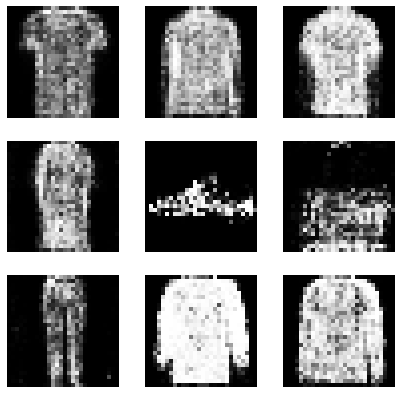

In [31]:
figure = plt.figure(figsize=(7, 7))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img = G(1).view(28, 28).detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Ploting Loss

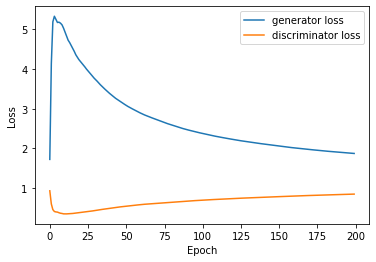

In [14]:
plt.plot( G_Losses, label = 'generator loss')
plt.plot( D_Losses, label = 'discriminator loss')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()